In [ ]:
%pip install diffusers transformers xformers accelerate
%pip install opencv-contrib-python
%pip install controlnet_aux

通过边缘检测绘制头像

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers.utils import load_image
from PIL import Image

image_file = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"original_image = load_image(image_file)

def get_canny_image(original_image, low_threshold=100, high_threshold=200):
  image = np.array(original_image)

  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_image = Image.fromarray(image)
  return canny_image

canny_image = get_canny_image(original_image)

def display_images(image1, image2):
  # Combine the images horizontally
  combined_image = Image.new('RGB', (image1.width + image2.width, max(image1.height, image2.height)))
  combined_image.paste(image1, (0, 0))
  combined_image.paste(image2, (image1.width, 0))
  # Display the combined image
  plt.imshow(combined_image)
  plt.axis('off')
  plt.show()

display_images(original_image, canny_image)



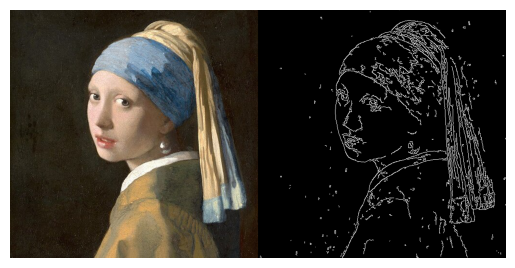

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Audrey Hepburn", "Elizabeth Taylor", "Scarlett Johansson", "Taylor Swift"]]
generator = [torch.Generator(device="cpu").manual_seed(42) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

通过“动态捕捉”来画人物图片

In [ ]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

image_file1 = "./data/rodin.jpg"
original_image1 = load_image(image_file1)
openpose_image1 = openpose(original_image1)

image_file2 = "./data/discobolos.jpg"
original_image2 = load_image(image_file2)
openpose_image2 = openpose(original_image2)

images = [original_image1, openpose_image1, original_image2, openpose_image2]
draw_image_grids(images, 2, 2)


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
poses = [openpose_image1, openpose_image2, openpose_image1, openpose_image2]

generator = [torch.Generator(device="cpu").manual_seed(42) for i in range(4)]
prompt1 = "batman character, best quality, extremely detailed"
prompt2 = "ironman character, best quality, extremely detailed"

output = pipe(
    [prompt1, prompt1, prompt2, prompt2],
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)

*结果*
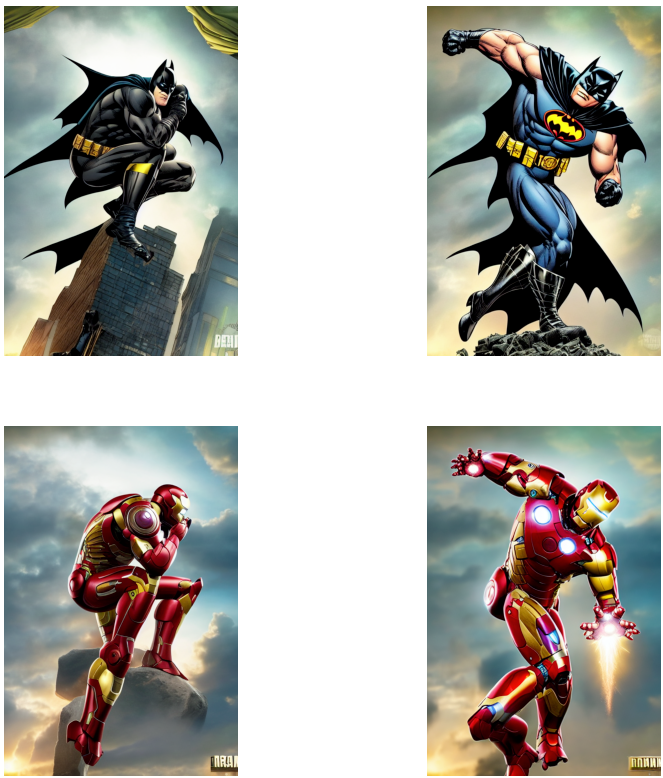

通过简笔画来画出好看的图片

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()


In [ ]:
from diffusers.utils import load_image

image_file = "./data/scribble_dog.png"
scribble_image = load_image(image_file)

generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "dog"
prompt = [prompt + t for t in [" in a room", " near the lake", " on the street", " in the forrest"]]
output = pipe(
    prompt,
    scribble_image,
    negative_prompt=["lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=50,
)


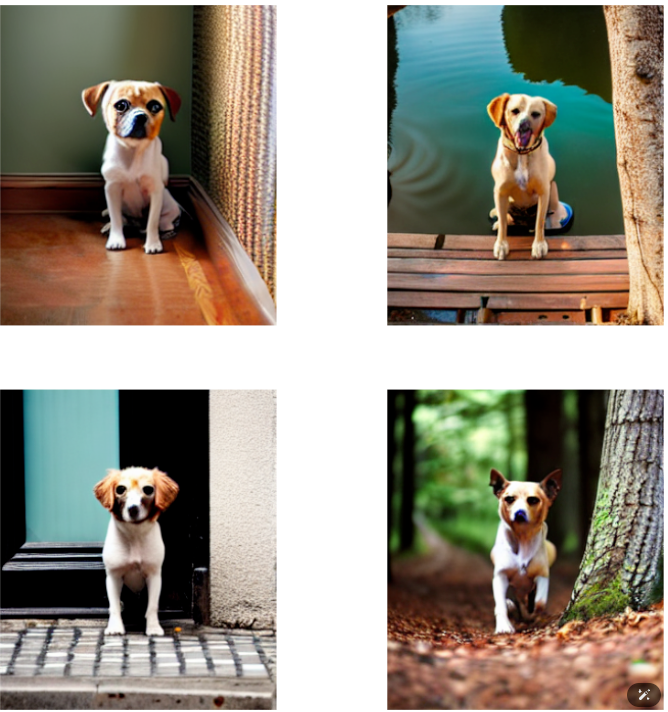

ControlNet 支持的模型 

ControlNet 一共训练了 8 个不同的模型，除了上面 3 个之外，还包括以下 5 种。 

HED Boundary，这是除 Canny 之外，另外一种边缘检测算法获得的边缘检测图片。我测试效果往往还比 Canny 更好一些。 

Depth，深度估计，也就是对一张图片的前后深度估计出来的轮廓图。 

Normal Map，法线贴图，通常在游戏中用得比较多，可以在不增加模型复杂性的情况下，提升细节效果。 

Semantic Segmentation，语义分割图，可以把图片划分成不同的区域模块。上一讲里我们拿来生成宫崎骏风格的城堡的底图，风格就类似于一个语义分割图。 
M-LSD，这个能够获取图片中的直线段，很适合用来给建筑物或者房间内的布局描绘轮廓。这个算法也常常被用在自动驾驶里面。